In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

In [111]:
digits = load_digits()
print(digits.keys())
data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]
print(data.dtype)

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])
float64


# 1.1 Exploring the Data

In [112]:
print(f"The shape of the image is {images[3].shape}")

The shape of the image is (8, 8)


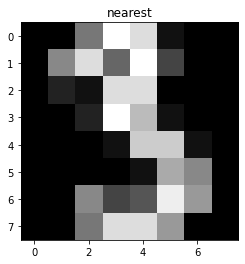

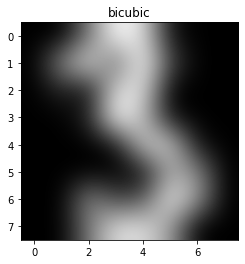

In [113]:
import numpy as np
import matplotlib.pyplot as plt
img = images[3]
assert 2 == len(img.shape)
plt.figure()
plt.gray()
plt.title("nearest")
plt.imshow(img, interpolation="nearest")
plt.show()
plt.figure()
plt.gray()
plt.title("bicubic")
plt.imshow(img, interpolation="bicubic")
plt.show()

In [114]:
from sklearn import model_selection
X_all = data
y_all = target
X_train, X_test, y_train, y_test = model_selection.train_test_split(digits.data, digits.target, test_size = 0.4, random_state = 0)

# 1.2 Distance function using loops

In [115]:
def dist_loop(training, test):
  n, _ = training.shape
  m, _ = test.shape

  distance_matrix = np.empty((n,m))

  for i, x_train in enumerate(training):
    for j, x_test in enumerate(test):
      distance_matrix[i, j] = np.linalg.norm(x_train - x_test)
  return distance_matrix

distances = dist_loop(X_train, X_test)
print(distances)
print(distances.shape)

[[55.67764363 53.12249994 56.56854249 ... 54.91812087 50.76416059
  46.87216658]
 [47.51841748 45.65084884 48.72371086 ... 45.475268   52.10566188
  40.18706259]
 [45.54119015 53.72150407 45.07771068 ... 44.96665431 50.8625599
  41.53311931]
 ...
 [46.         45.54119015 46.28174586 ... 51.32250968 44.62062303
  48.61069841]
 [44.98888752 49.07137659 53.55371136 ... 57.91372894 27.80287755
  40.28647416]
 [44.77722635 41.07310556 40.31128874 ... 43.78355856 52.
  44.22668877]]
(1078, 719)


# 1.3 Distance function computation using vectorization

In [116]:
def dist_vec(training, test):
  n, _ = training.shape
  m, _ = test.shape

  distance_matrix = np.empty((n,m))

  training_rollout = np.repeat(training, m, axis=0) # rollout every training set m times
  test_rollout = np.concatenate([test]*n) # rollout complete test set n times

  distance_matrix = np.linalg.norm(training_rollout - test_rollout, axis=1)
  distance_matrix = np.reshape(distance_matrix, (n, m))
  return distance_matrix

distances = dist_vec(X_train, X_test)
print(distances)
print(distances.shape)

[[55.67764363 53.12249994 56.56854249 ... 54.91812087 50.76416059
  46.87216658]
 [47.51841748 45.65084884 48.72371086 ... 45.475268   52.10566188
  40.18706259]
 [45.54119015 53.72150407 45.07771068 ... 44.96665431 50.8625599
  41.53311931]
 ...
 [46.         45.54119015 46.28174586 ... 51.32250968 44.62062303
  48.61069841]
 [44.98888752 49.07137659 53.55371136 ... 57.91372894 27.80287755
  40.28647416]
 [44.77722635 41.07310556 40.31128874 ... 43.78355856 52.
  44.22668877]]
(1078, 719)


Here, we tested whether the numpy function 'meshgrid' provides a faster alternative for associating all datasets of training and test.

In [117]:
def dist_vec_meshgrid(training, test):
  n, _ = training.shape
  m, _ = test.shape

  x, y = np.meshgrid(range(n), range(m), indexing='ij') # build n to m relation between training and test data

  distance_matrix = np.linalg.norm(training[x.flatten()] - test[y.flatten()], axis=1)
  distance_matrix = np.reshape(distance_matrix, (n, m))
  return distance_matrix

distances = dist_vec_meshgrid(X_train, X_test)
print(distances)

[[55.67764363 53.12249994 56.56854249 ... 54.91812087 50.76416059
  46.87216658]
 [47.51841748 45.65084884 48.72371086 ... 45.475268   52.10566188
  40.18706259]
 [45.54119015 53.72150407 45.07771068 ... 44.96665431 50.8625599
  41.53311931]
 ...
 [46.         45.54119015 46.28174586 ... 51.32250968 44.62062303
  48.61069841]
 [44.98888752 49.07137659 53.55371136 ... 57.91372894 27.80287755
  40.28647416]
 [44.77722635 41.07310556 40.31128874 ... 43.78355856 52.
  44.22668877]]


In [118]:
%timeit -r 2 -n 2 dist_loop(X_train, X_test)
%timeit -r 2 -n 2 dist_vec(X_train, X_test)
%timeit -r 2 -n 2 dist_vec_meshgrid(X_train, X_test)

2 loops, best of 2: 5.81 s per loop
2 loops, best of 2: 322 ms per loop
2 loops, best of 2: 289 ms per loop


# 1.4 Implement the k-nearest neighbor classifier

In [119]:
def k_nearest_neighbor(k, X_train, X_test, y_train):
  distances = dist_vec(X_train, X_test)
  k_nearest_indices = np.argpartition(distances, k, axis=0)[0:k]
  return k_nearest_indices
output = k_nearest_neighbor(3, X_train, X_test, y_train)
print(output)
print(output.shape)

[[919 654 105 ... 317   7 582]
 [174 870 636 ... 515 470 214]
 [683 521 191 ... 723 718 406]]
(3, 719)


In [120]:
def filter_out_3_and_9():
  filter_3_idx = np.where(target==3)[0]
  filter_9_idx = np.where(target==9)[0]
  filtered_idx = np.sort(np.concatenate((filter_3_idx, filter_9_idx)))
  x_filtered = data[filtered_idx]
  y_filtered = target[filtered_idx]
  return model_selection.train_test_split(x_filtered, y_filtered, test_size = 0.4, random_state = 0)
X_train_39, X_test_39, y_train_39, y_test_39 = filter_out_3_and_9()

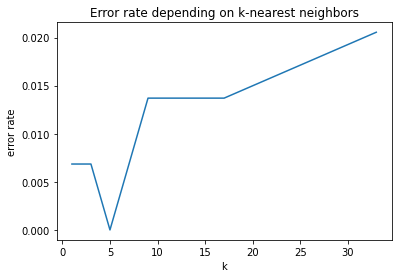

In [121]:
def k_nearest_neighbour(k, x_train, x_test, y_train):
  m,_ = x_test.shape
  y_pred = np.zeros((m), dtype=int)
  distances = dist_vec(x_train, x_test)
  k_nearest_idx = np.argpartition(distances, k, axis=0)[0:k]
  y_values = y_train[k_nearest_idx]
  for idx in range(m):
    y_pred[idx] = np.argmax(np.bincount(y_values[:, idx]))
  return y_pred

ks = [1, 3, 5, 9, 17, 33]
y_pred = np.zeros((len(ks),X_test_39.shape[0]))
for i, k in enumerate(ks):
  y_pred[i] = k_nearest_neighbour(k, X_train_39, X_test_39, y_train_39)
y_true_labels = [y_test_39]*(len(ks))
errors = np.sum(y_true_labels != y_pred, axis=1)
error_rate = errors / X_test_39.shape[0]
plt.plot(ks, error_rate)
plt.title("Error rate depending on k-nearest neighbors")
plt.xlabel("k")
plt.ylabel("error rate")
plt.show()

We observe that with greater k the error rate gets higher. This may be caused by errors arising with greater distance when looking at more neighbors. This increases the chance to include more datasets with the wrong label. The best result is achieved with $k=5$.

# 2 Cross-validation

In [122]:
def split_folds(data, target, L):
  return 0,0

X_folds, y_folds = split_folds(data, target, L)

NameError: ignored